In [1]:
# Load modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import pandas as pd
from keras.regularizers import L2

# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 20
plt.rcParams['font.size'] = font_size

# Add your own import statements if needed

In [2]:
# Load and unpack a compressed npy array
load_data = np.load('data_project2.npz')
data = load_data['arr_0']


# Remove data where data[:, -1, 1:5] = 0, i.e.
# where the particles get stuck in (0, 0)
data = data[np.sum(data[:,-1,1:5], axis=1) != 0]

N,time_steps, variables = data.shape
# Rng
rng = np.random.default_rng(seed=19)
# rng.shuffle(data)


In [3]:

# Split the data into training and validation sets
t_train = data[:int(N*0.9), :, 0]
x_2_train = data[:int(N*0.9),0,3].reshape(-1,1) @ np.ones((1, 1000))
y_2_train = data[:int(N*0.9),0,4].reshape(-1,1) @ np.ones((1, 1000))
print(t_train.shape, x_2_train.shape, y_2_train.shape)

t_val = data[-int(N*0.1)-1:, :, 0]
x_2_val = data[-int(N*0.1)-1:,0,3].reshape(-1,1) @ np.ones((1, 1000))
y_2_val = data[-int(N*0.1)-1:,0,4].reshape(-1,1) @ np.ones((1, 1000))

train_data = np.dstack((t_train, x_2_train, y_2_train))
val_data = np.dstack((t_val, x_2_val, y_2_val))

train_targets = data[:int(data.shape[0]*0.9), :, (1, 2, 3, 4)]
val_targets = data[-int(data.shape[0]*0.1)-1:, :, (1, 2, 3, 4)]

print(train_data.shape)
print(val_data.shape)


(6860, 1000) (6860, 1000) (6860, 1000)
(6860, 1000, 3)
(763, 1000, 3)


In [202]:
# Helping functions
def get_data(idx):
    """
    Get one training instance from the data set at the index idx. 
    
    The data is assumed to be in an array `data`.
    
    Args:
        idx (int): An integer specifying which of the training example to fetch
        
    Returns:
        x (array): An array of shape (time_steps, 3) which specifies the input to
                   the neural network. The first column is the time and the second
                   and third columns specify the (x, y) coordinates of the second
                   particle. Note that the first particle is always assumed to be
                   at (1, 0) and the third particle can be inferred from the first
                   and second particle's position.
                   
        y (array): An array of shape (time_steps, 4) which specifies the output that 
                   is expected from the neural network.
                   
                   The first two columns specify the (x, y) coordinates of the first
                   particles and the next two columns give the coordinates of the 
                   second particle for the specified time (length of the columns).
                   The third particles position can be inferred from the first
                   and second particle's position.
    """
    raise NotImplementedError

def get_trajectories(pred, indx):
    """
    Gets the trajectories from a predicted output pred.
    
    Args:
        pred (array): An array of shape (N, 4) where N is the number of time
                      steps. The four columns give the positions of the particles
                      1 and 2 for all the time steps.
    Returns:
        p1, p2, p3 (tuple of arrays): Three arrays of dimensions (N, 2) where N is the number 
                             of time steps and the two columns for each array give 
                             the positions of the three particles (p1, p2, p3)
    """
    if indx == None:
        x1 = pred[:,:,0];x2 = pred[:,:,2]
        x3 = -x2 - x1
        y1 = pred[:,:,1];y2 = pred[:,:,3]
        y3 = -y1 -y2
    else:
        x1 = pred[indx,:,0];x2 = pred[indx,:,2]
        x3 = -x2 - x1
        y1 = pred[indx,:,1];y2 = pred[indx,:,3]
        y3 = -y1 -y2
        
    p1 = np.dstack((x1, y1))
    p2 = np.dstack((x2, y2))
    p3 = np.dstack((x3, y3))
    return p1, p2, p3 

def plot_trajectories(traject_model,traject_pre,traject_true,model,trajectory_number, ax=None,save_traj = False, **kwargs):
    """
    Plots trajectories for points p1, p2, p3
    
    Args:
        p1, p2, p3 (array): Three arrays each of shape (n, 2) where n is the number
                            of time steps. Each array is the (x, y) position for the
                            particles
        ax (axis object): Default None, in which case a new axis object is created.
        kwargs (dict): Optional keyword arguments for plotting
    
    Returns:
        ax: Axes object
    """
    fig, ax = plt.subplots(1,2,figsize=(19,8),sharey=True)
    p1, p2, p3 = get_trajectories(traject_model,trajectory_number)

    ax[0].plot(p1[0,:,0], p1[0,:,1], label=f'$(x_1,y_1)$ {model}', **kwargs,color='tab:blue',linestyle='--')
    ax[0].plot(p2[0,:,0], p2[0,:,1], label=f'$(x_2,y_2)$ {model}', **kwargs,color='tab:red',linestyle='--')
    ax[0].plot(p3[0,:,0], p3[0,:,1], label=f'$(x_3,y_3)$ {model}', **kwargs,color='tab:green',linestyle='--')
    
    p1, p2, p3 = get_trajectories(traject_true,trajectory_number)
    ax[0].plot(p1[0,:,0], p1[0,:,1], label=f'$(x_1,y_1)$ Target', **kwargs,color='tab:blue',alpha=0.5)
    ax[0].plot(p2[0,:,0], p2[0,:,1], label=f'$(x_2,y_2)$ Target', **kwargs,color='tab:red',alpha=0.5)
    ax[0].plot(p3[0,:,0], p3[0,:,1], label=f'$(x_3,y_3)$ Target', **kwargs,color='tab:green',alpha=0.5)
    ax[0].plot(p1[0,0,0], p1[0,0,1], marker='o' , **kwargs,color='tab:blue',markersize=10)
    ax[0].plot(p2[0,0,0], p2[0,0,1], marker='o', **kwargs,color='tab:red',markersize=10)
    ax[0].plot(p3[0,0,0], p3[0,0,1], marker='o', **kwargs,color='tab:green',markersize=10)
    ax[0].plot(p1[0,-1,0], p1[0,-1,1], marker='s' , **kwargs,color='tab:blue',markersize=10)
    ax[0].plot(p2[0,-1,0], p2[0,-1,1], marker='s', **kwargs,color='tab:red',markersize=10)
    ax[0].plot(p3[0,-1,0], p3[0,-1,1], marker='s', **kwargs,color='tab:green',markersize=10)
    ax[0].legend()
    ax[0].set_xlabel('$x$')
    ax[0].set_ylabel('$y$')

    p1, p2, p3 = get_trajectories(traject_pre,trajectory_number)

    ax[1].plot(p1[0,:,0], p1[0,:,1], label=f'$(x_1,y_1)$ Pre-trained', **kwargs,color='tab:blue',linestyle='--')
    ax[1].plot(p2[0,:,0], p2[0,:,1], label=f'$(x_2,y_2)$ Pre-trained', **kwargs,color='tab:red',linestyle='--')
    ax[1].plot(p3[0,:,0], p3[0,:,1], label=f'$(x_3,y_3)$ Pre-trained', **kwargs,color='tab:green',linestyle='--')
    
    p1, p2, p3 = get_trajectories(traject_true,trajectory_number)
    ax[1].plot(p1[0,:,0], p1[0,:,1], label=f'$(x_1,y_1)$ Target', **kwargs,color='tab:blue',alpha=0.5)
    ax[1].plot(p2[0,:,0], p2[0,:,1], label=f'$(x_2,y_2)$ Target', **kwargs,color='tab:red',alpha=0.5)
    ax[1].plot(p3[0,:,0], p3[0,:,1], label=f'$(x_3,y_3)$ Target', **kwargs,color='tab:green',alpha=0.5)
    ax[1].plot(p1[0,0,0], p1[0,0,1], marker='o' , **kwargs,color='tab:blue',markersize=10)
    ax[1].plot(p2[0,0,0], p2[0,0,1], marker='o', **kwargs,color='tab:red',markersize=10)
    ax[1].plot(p3[0,0,0], p3[0,0,1], marker='o', **kwargs,color='tab:green',markersize=10)
    ax[1].plot(p1[0,-1,0], p1[0,-1,1], marker='s' , **kwargs,color='tab:blue',markersize=10)
    ax[1].plot(p2[0,-1,0], p2[0,-1,1], marker='s', **kwargs,color='tab:red',markersize=10)
    ax[1].plot(p3[0,-1,0], p3[0,-1,1], marker='s', **kwargs,color='tab:green',markersize=10)
    ax[1].legend()
    ax[1].set_xlabel('$x$')
    #ax[1].set_ylabel('$y$')
    #ax[1].text(0.035,-0.35,'b)',fontsize = 28)
    #ax[0].text(0.035,-.35,'a)',fontsize = 28)
        
    plt.tight_layout()

    if save_traj:
        plt.savefig(f'trajectories {trajectory_number} for {model}.pdf')    
    return ax

In [193]:
def plot_history(history,model_name, loss=None, save_training_curves = False):
    plt.figure(figsize=(8,6))
    lw = 2
    train_loss = history['loss']
    val_loss = history['val_loss']
    plt.plot(train_loss, label='Training loss', color='tab:blue',lw = lw, marker='o',ms = 4)
    plt.plot(val_loss, label='Validation loss', color='k', linestyle='solid',lw=lw, marker='x',ms = 4,alpha=0.5)
    #for key in history.history.keys():
    #    plt.plot(history.history[key],label=key)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    if loss is not None:
        plt.text(0.5,0.5,f'Loss: {loss[0]:.4f}',transform=plt.gca().transAxes)
    if save_training_curves:
        plt.savefig(f'Training curve {model_name}.pdf')

def save_model(model,model_name):
    model.save(f'{model_name}.keras')


In [6]:
pre_trained_model = keras.models.load_model('Breen_NN_project2.keras')
#pre_trained_model.summary()
pre_trained_model.trainable = False


batch_size_train = int(68e3)
batch_size_val = int(7e3)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data.reshape(-1,3), train_targets.reshape(-1,4))).batch(batch_size_train)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data.reshape(-1,3), val_targets.reshape(-1,4))).batch(batch_size_val)

pre_trained_model.summary(show_trainable=True)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ dense_78 (Dense)            │ (None, 128)           │        512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_79 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_80 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_81 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_82 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_83 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_84 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_85 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_86 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_87 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_88 (Dense)            │ (None, 4)             │        516 │   N   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 149,636 (1.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 149,636 (1.14 MB)

In [7]:
model_10_Dense = keras.models.Sequential([   
    keras.layers.Dense(128, activation='relu', input_shape=(3,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(4,activation='linear')
])

model_5_Dense = keras.models.Sequential([   
    keras.layers.Dense(64, activation='relu', input_shape=(3,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4)
])

model_cnn = keras.models.Sequential([
    keras.layers.Conv1D(filters = 128, kernel_size = 3, activation='relu',input_shape=(3,1)),
    keras.layers.Conv1D(filters = 64, kernel_size = 1, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4)
])


lstm_model = keras.models.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(64,recurrent_regularizer=L2(0.01),return_sequences=True),input_shape=(3,1)),
    keras.layers.LSTM(32,return_sequences=False),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=4)
])


mixed_model = keras.models.Sequential([
    keras.layers.Conv1D(filters = 128, kernel_size = 3, activation='relu',input_shape=(3,1)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=4)
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an 

In [8]:
def training_models(model,epochs, train_data, val_data,earlystop = True, loss_function=keras.losses.MeanAbsoluteError(), metric='mean_absolute_error', learning_rate=0.002, patience=10):

    ''' Function to train a model and return the history, model and time taken to train'''
    

    model.compile(loss=loss_function,
            optimizer=tf.optimizers.Adam(learning_rate,0.75,0.99),
            metrics=[metric])
    
    if earlystop:

        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,mode='min',restore_best_weights = True)
        start = time.time()
        history = model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[early_stopping])
        end = time.time()
        t = end-start
        print(f'Time to run: {t:.1f}s')
    else:
        start = time.time()
        history = model.fit(train_data, epochs=epochs, validation_data=val_data)
        end = time.time()
        t = end-start
        print(f'Time to run: {t:.1f}s')
    
    
    return history,model,t

In [9]:
epochs = 200

# history_dense,modelchoose_model_training('Dense','Dense',epochs)

#history_cnn, model_cnn, t_cnn = training_models(model_cnn, epochs, train_dataset, val_dataset, earlystop=True)
#history_lstm, model_lstm, t_lstm = training_models(lstm_model, epochs, train_dataset, val_dataset,earlystop=True)
# history_pre, model_pre, t_pre = training_models(pre_trained_model, epochs, 'mean_squared_error', 'mean_squared_error', 0.001, 10, train_dataset, val_dataset)
#history_5, model_5, t_5 = training_models(model_5_Dense, epochs, train_dataset, val_dataset, earlystop=True)
# history_10, model_10, t_10 = training_models(model_10_Dense, epochs, train_dataset, val_dataset, earlystop=True)
#history_mixed, model_mixed, t_mixed = training_models(mixed_model, epochs, train_dataset, val_dataset, earlystop=True)



In [196]:
def prediction(model, targets,data):
    traject = np.zeros((targets.shape))
    for time_step in range(targets.shape[1]):
        if time_step == 0:
            traject[:,time_step,:] = targets[:,time_step,:]
        else:
            traject[:,time_step,:] = model.predict(data[:,time_step,:],verbose=0) 
    return traject

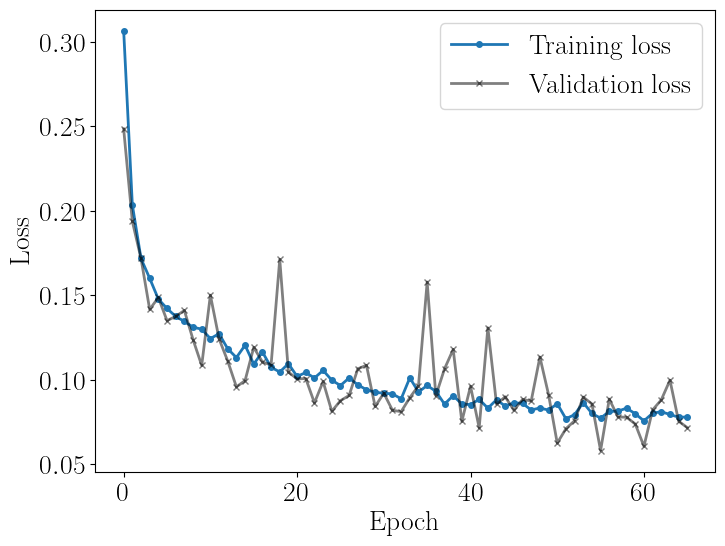

In [11]:
# Plot the training curves

import pickle
#loss = model_10.evaluate(val_dataset)
#print(f'Loss: {loss}')

with open('models/trainHistoryDict_10','rb') as file_pi:
    history_10 = pickle.load(file_pi)

plot_history(history_10, 'history_10', save_training_curves = False)

#save_model(model_mixed,'model_mixed')

In [12]:
model_5_dense = keras.models.load_model('models/model_5_Dense.keras')
model_10_dense = keras.models.load_model('models/model_10_Dense.keras')
model_cnn = keras.models.load_model('models/model_cnn.keras')
model_lstm = keras.models.load_model('models/model_lstm.keras')
model_mixed = keras.models.load_model('models/model_mixed.keras')


In [154]:
traject_dense_5 = prediction(model_5_dense, val_targets, val_data)

In [155]:
traject_10_dense = prediction(model_10_dense, val_targets, val_data)

In [156]:
traject_cnn = prediction(model_cnn, val_targets, val_data)

In [157]:
traject_lstm = prediction(lstm_model, val_targets, val_data)

In [158]:
traject_mixed = prediction(mixed_model, val_targets, val_data)

In [198]:
traject_pre = prediction(pre_trained_model, val_targets, val_data)

In [72]:
tr_num = 2

array([<Axes: xlabel='$x$', ylabel='$y$'>, <Axes: xlabel='$x$'>],
      dtype=object)

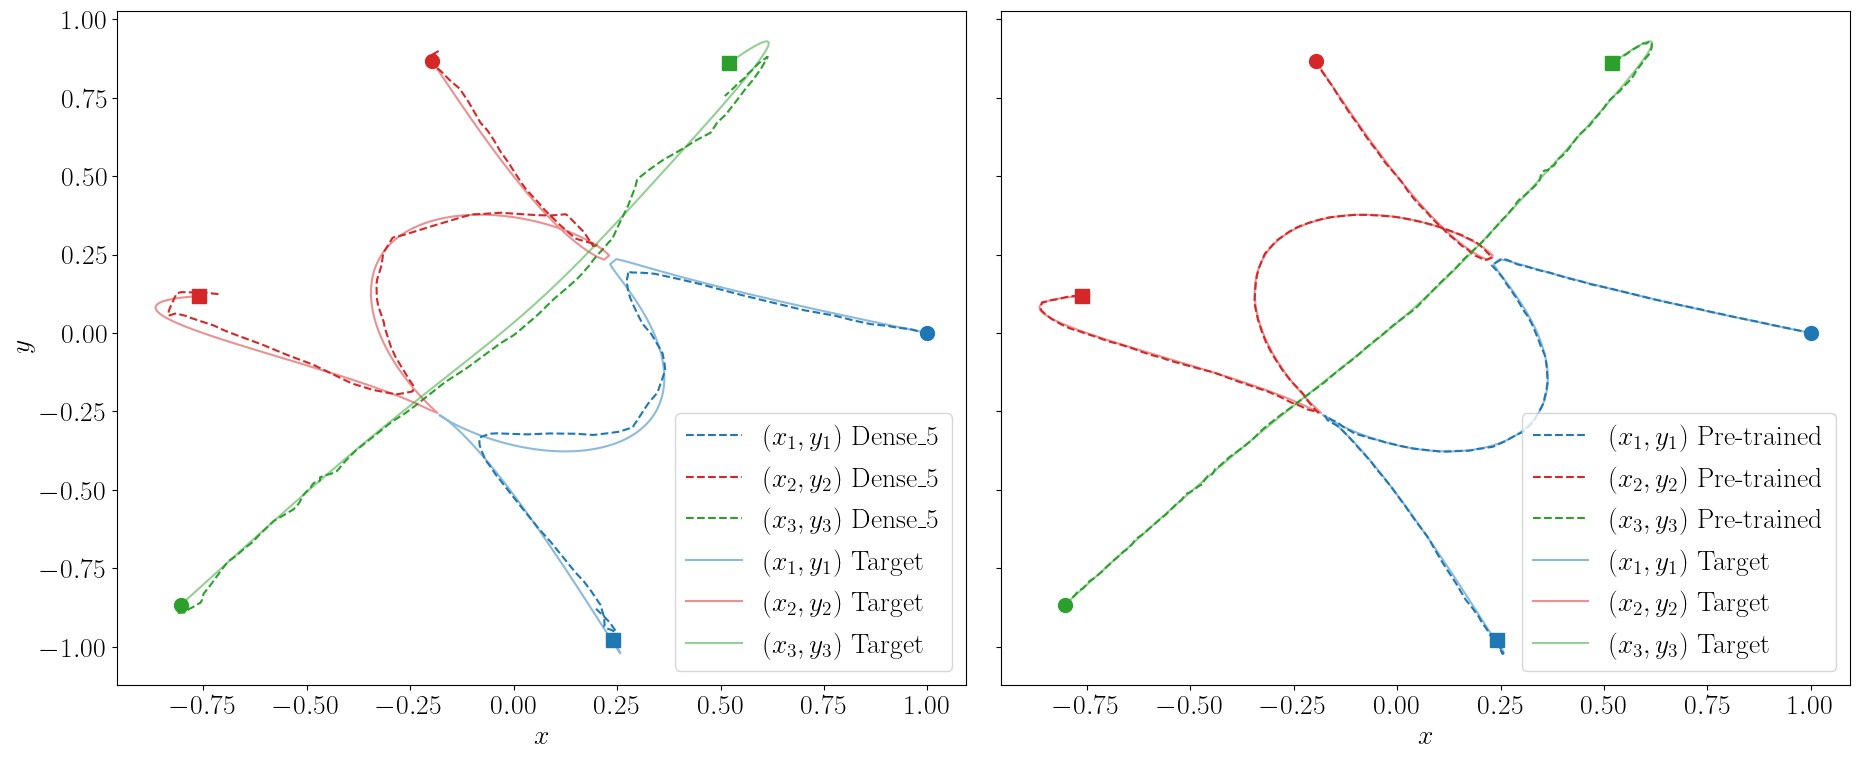

In [168]:
plot_trajectories(traject_dense_5,traject_pre, val_targets,
                model = 'Dense_5', trajectory_number=tr_num)


array([<Axes: xlabel='$x$', ylabel='$y$'>, <Axes: xlabel='$x$'>],
      dtype=object)

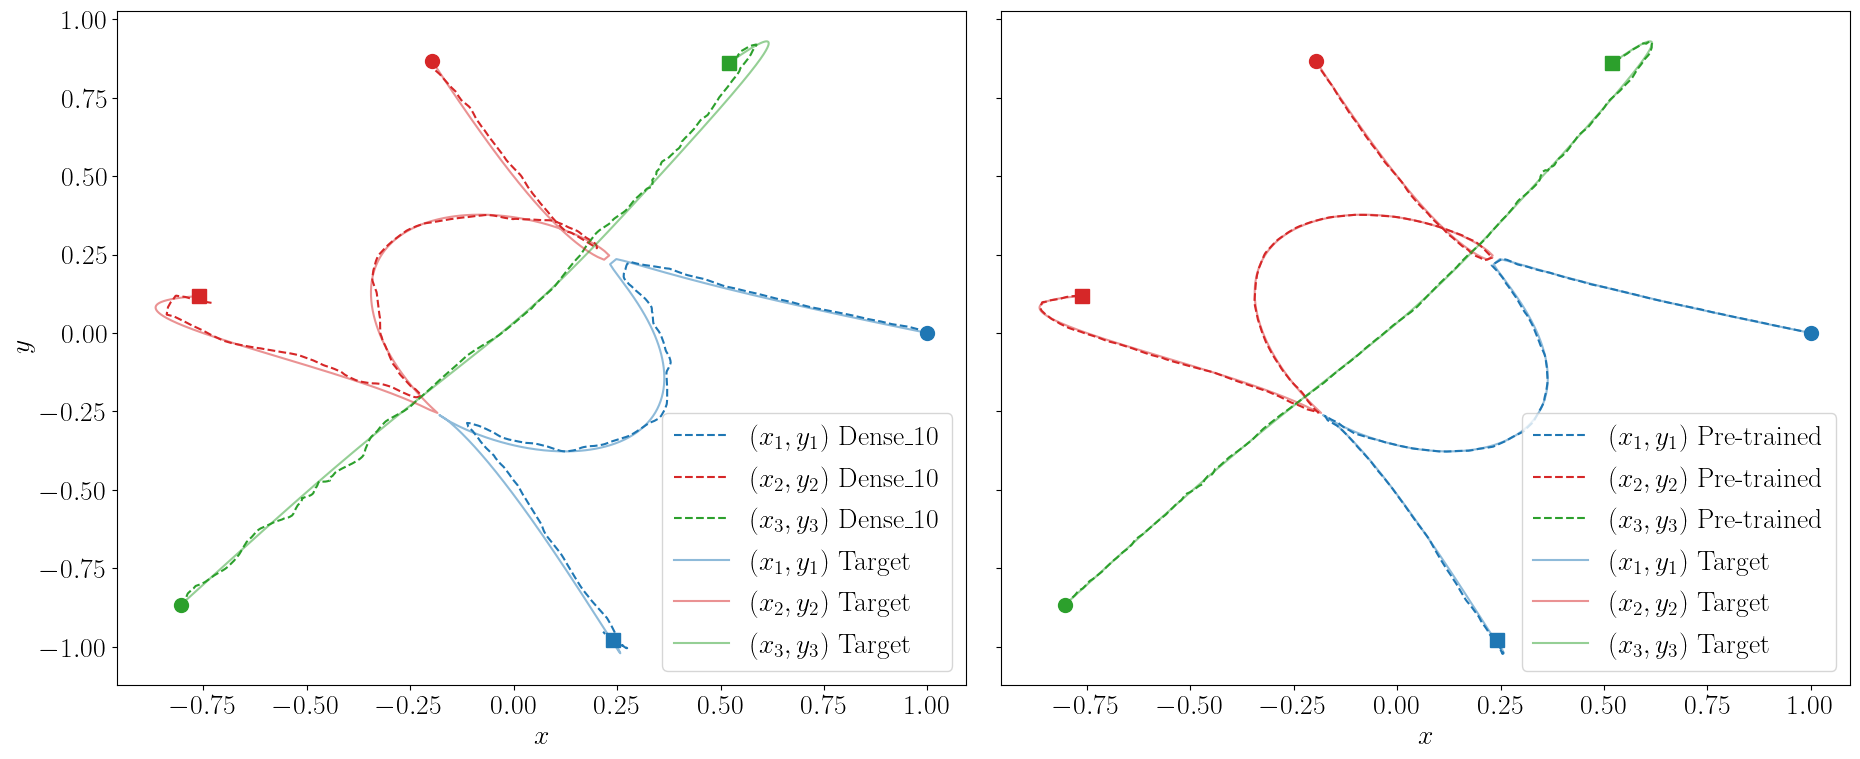

In [169]:
plot_trajectories(traject_10_dense,traject_pre, val_targets,
                model = 'Dense_10', trajectory_number=tr_num)


array([<Axes: xlabel='$x$', ylabel='$y$'>, <Axes: xlabel='$x$'>],
      dtype=object)

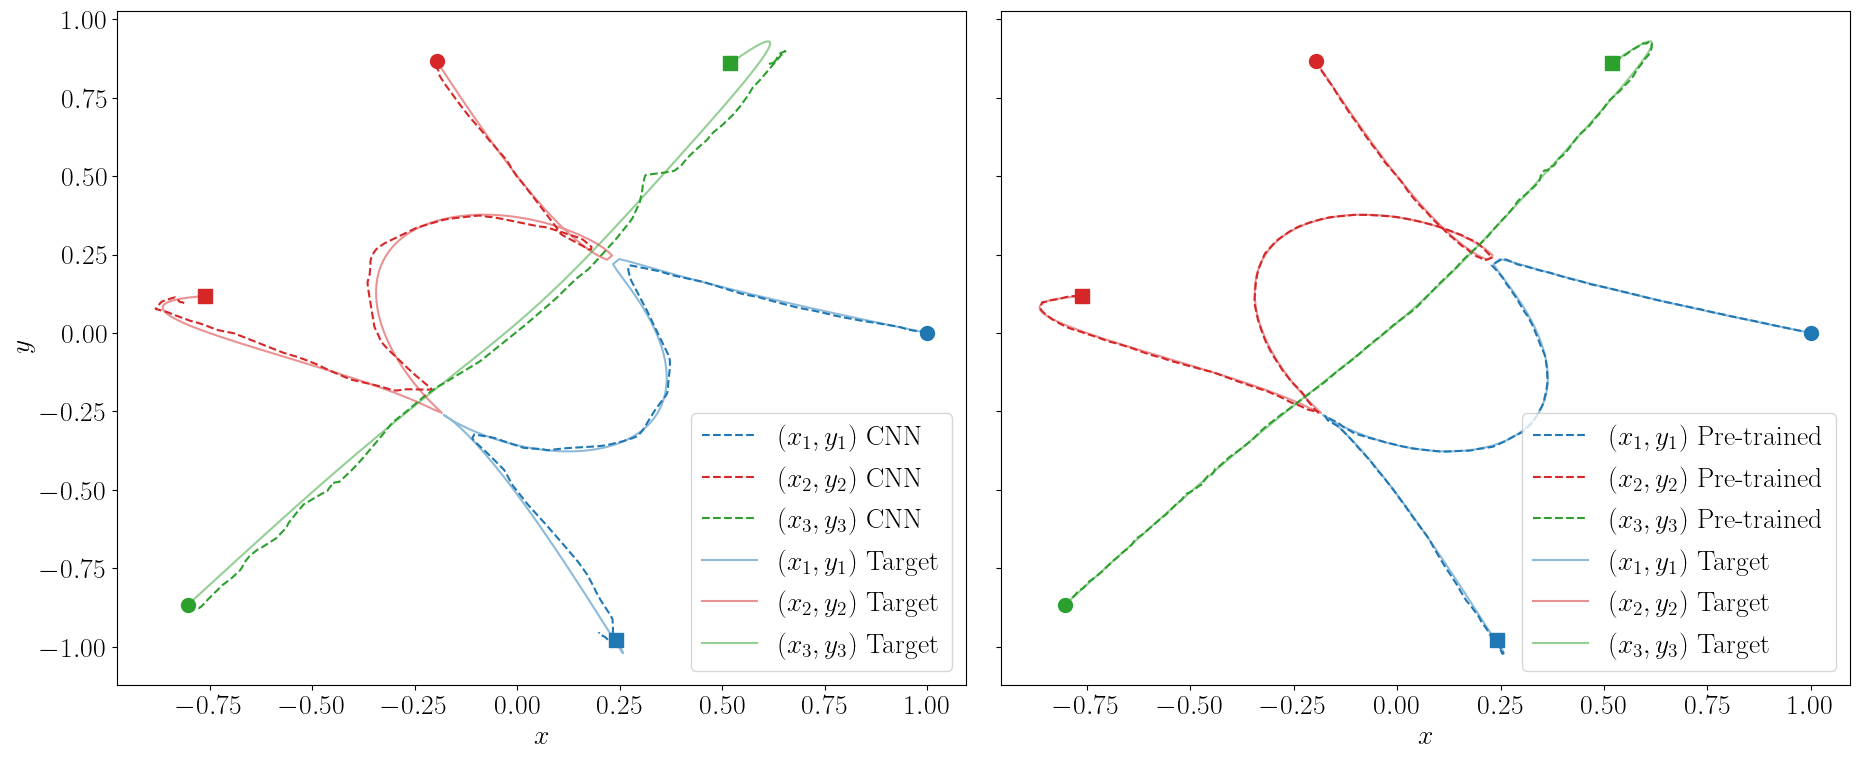

In [170]:

plot_trajectories(traject_cnn,traject_pre, val_targets,
               model = 'CNN', trajectory_number=tr_num)


array([<Axes: xlabel='$x$', ylabel='$y$'>, <Axes: xlabel='$x$'>],
      dtype=object)

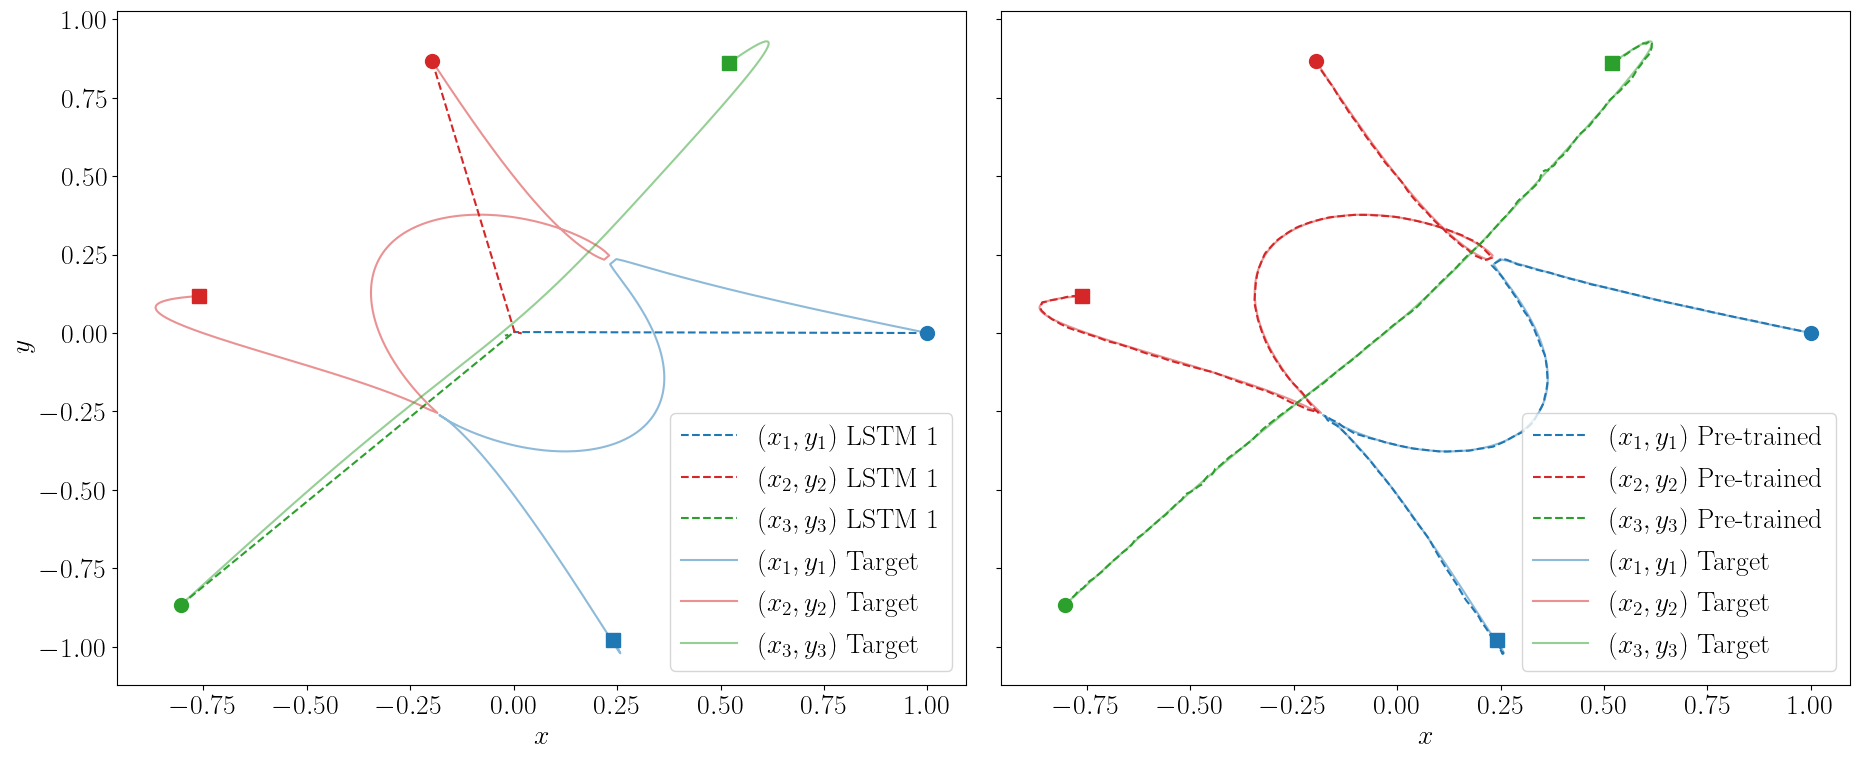

In [171]:

plot_trajectories(traject_lstm,traject_pre, val_targets,
                model = 'LSTM 1', trajectory_number=tr_num)


array([<Axes: xlabel='$x$', ylabel='$y$'>, <Axes: xlabel='$x$'>],
      dtype=object)

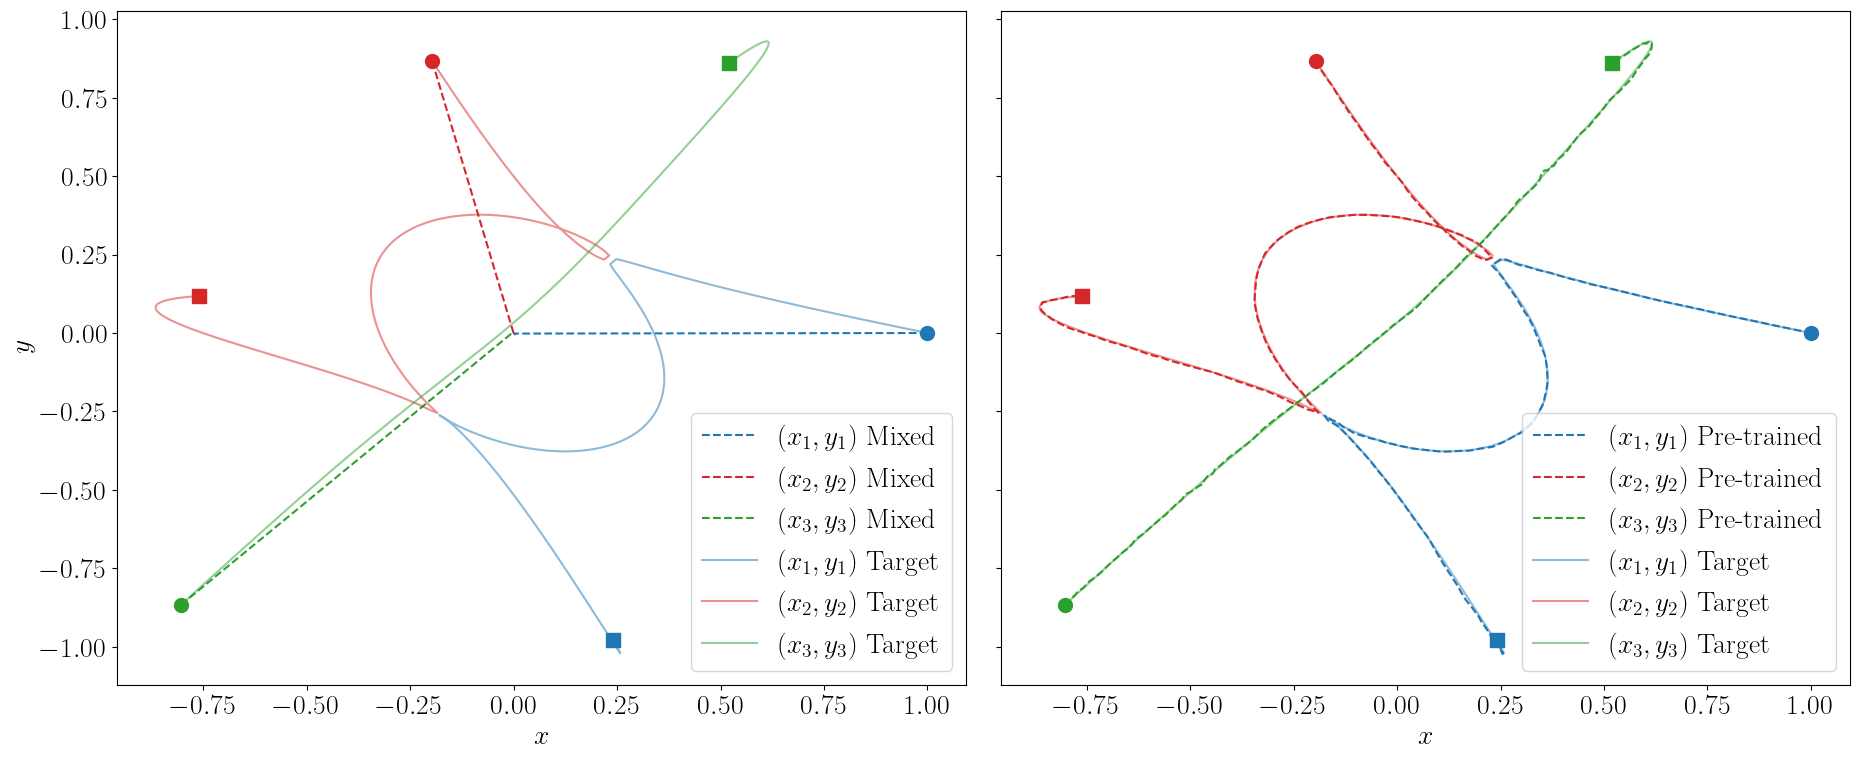

In [172]:

plot_trajectories(traject_mixed,traject_pre, val_targets,
                model = 'Mixed', trajectory_number=tr_num)

Text(0.5, 1.0, 'Disturbed initial positions of particle 2')

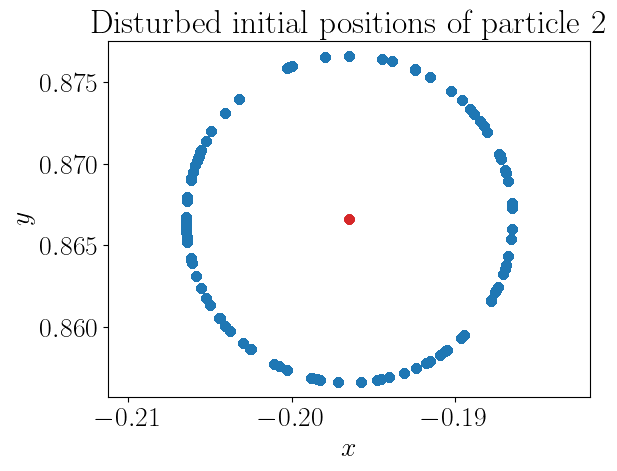

In [73]:
val_data_init_true = val_data[tr_num,0,:][1:].reshape(-1,1) @ np.ones((1,100))
t_dist = t_train[:100,:]


rng = np.random.default_rng(seed=19)
phi = rng.uniform(0, 2*np.pi, size = 100)
r = 0.01 * np.array([np.cos(phi), np.sin(phi)])
val_dist_x = (val_data_init_true[0] + r[0]).reshape(-1,1)
val_dist_y = (val_data_init_true[1] + r[1]).reshape(-1,1)


val_dist = np.dstack((t_dist, val_dist_x@ np.ones((1, 1000)), val_dist_y@ np.ones((1, 1000))))

plt.plot(val_dist[:,:,1],val_dist[:,:,2],color='tab:blue',marker='o',linestyle='')
plt.axis('equal')
plt.xlabel('$x$') 
plt.ylabel('$y$')
plt.plot(val_data_init_true[0],val_data_init_true[1],color='tab:red',marker='o',linestyle='')
plt.tight_layout()
plt.title('Disturbed initial positions of particle 2')


In [79]:
def dist_plotter(true_dist_traj,dist_traj,pre_dist_traj,indx = None,t_steps = [1,250,500,750,1000],save_disturbed = False):
    _,p2_model,_ = get_trajectories(dist_traj,indx)
    _,p2_true,_ = get_trajectories(true_dist_traj,indx)
    _,p2_pre,_ = get_trajectories(pre_dist_traj,indx)
    fig,ax = plt.subplots(1,2,figsize=(16,7),sharey=True)

    ax[0].plot(p2_model[:,:,0],p2_model[:,:,1],color = 'tab:blue',lw = 0.5,alpha = 0.075)
    for t in t_steps:
        if t == 1000:
            ax[0].plot(p2_model[:,t-1,0],p2_model[:,t-1,1],'o',ms = 2,color = 'blue',label = 'Dense_10 at $t_i$',alpha = 0.8)
            ax[1].plot(p2_pre[:,t-1,0],p2_pre[:,t-1,1],'o',ms = 2,color = 'blue',label = 'Pre-trained at $t_i$')
        else:
            ax[0].plot(p2_model[:,t-1,0],p2_model[:,t-1,1],'o',ms = 2,color = 'blue')
            ax[1].plot(p2_pre[:,t-1,0],p2_pre[:,t-1,1],'o',ms = 2,color = 'blue')

    ax[0].plot(p2_true[0,:,0],p2_true[0,:,1],color = 'k',linestyle = 'dashed',lw = 2,alpha = 0.5,label = 'True')
    ax[0].legend()
    
    
    ax[1].plot(p2_pre[:,:,0],p2_pre[:,:,1],color = 'tab:blue',lw = 0.5,alpha = 0.05)

    ax[0].plot(p2_true[0,-1,0],p2_true[0,-1,1],'s',color = 'k',ms = 10,alpha = 0.7)
    ax[1].plot(p2_true[0,:,0],p2_true[0,:,1],color = 'k',linestyle = 'dashed',lw = 2,alpha = 0.5,label = 'True')
    ax[1].legend()
    ax[1].plot(p2_true[0,-1,0],p2_true[0,-1,1],'s',color = 'k',ms = 10,alpha = 0.7)
    #ax[0].plot([],[],'tab:blue','-', label='ANN')
    #ax[1].plot([],[],'tab:blue','-', label='Brutus')
    
    ax[1].text(-0.325,-.55,'b)',fontsize = 28)
    ax[1].set_xlabel('$x$')
    ax[0].set_xlabel('$x$')
    ax[0].set_ylabel('$y$')
    ax[0].text(-0.325,-.55,'a)',fontsize = 28)
    
    ax[1].legend()
    plt.tight_layout()

    if save_disturbed:
        plt.savefig('Disturbed trajectories.pdf')

In [75]:
val_tar_dist = val_targets[tr_num,:,:]
val_tar_dist = np.tile(val_tar_dist, (100, 1, 1))

traject_dist = prediction(model_10_dense,val_tar_dist,val_dist)
traject_dist_pre = prediction(pre_trained_model,val_tar_dist,val_dist)

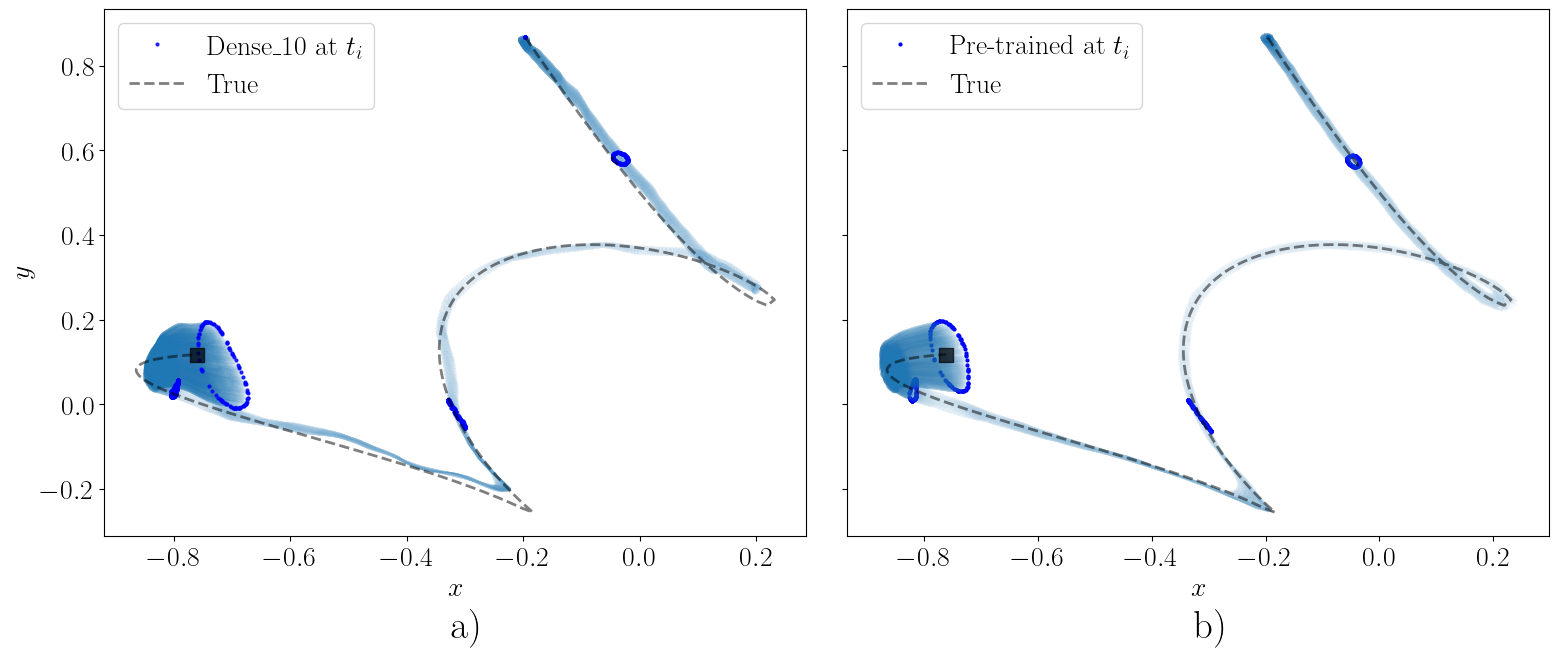

In [81]:
dist_plotter(val_tar_dist,traject_dist,traject_dist_pre,save_disturbed = True)

In [214]:
import keras_tuner

# The chosen optimization
from keras_tuner.tuners import BayesianOptimization



In [215]:
def build_model_MyModel(hp):
  model_tuned = keras.Sequential([
    # First LSTM Layer
    keras.layers.Dense(units=64,activation='relu',input_shape=(3,)),
    keras.layers.Dense(units=64,activation='relu'),
    keras.layers.Dense(units=64,activation='relu'),

    keras.layers.Dense(4)
  ])
  model_tuned.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-5,1e-4,1e-3,1e-2,0.1,0.5])),
              loss = tf.losses.MeanAbsoluteError(),
              #loss=hp.Choice('loss_function',[loss_f for loss_f in loss.values()]),
              metrics=['mean_absolute_error'])

  return model_tuned

In [216]:
MAX_TRIALS = 10            # This was set a bit lower just to ensure that running times were kept low  
EXECUTION_PER_TRIAL = 2 

class MyTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)
  

tuner = MyTuner(
    build_model_MyModel,
    max_trials=MAX_TRIALS,
    objective='val_loss',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    overwrite=True,
    num_initial_points=10, 
    project_name='Tuning_5_Dense')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [217]:
tune = True

if tune:

    noepochauto = 6  
    #es = keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)
    
    tuner.search(train_dataset, epochs=noepochauto, validation_data=val_dataset)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.1               |0.1               |learning_rate

Epoch 1/6
 761/1372 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4001 - mean_absolute_error: 0.4001

KeyboardInterrupt: 

In [196]:
model = tuner.get_best_models(num_models=1)[0]

# Print the hyperparameters from the best model

vals = tuner.get_best_hyperparameters(num_trials=5)[0].values
for keys,values in vals.items():
    print('%20s = %3.4g' %(keys,values))

model.summary()

       learning_rate = 0.001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,836 (34.52 KB)

 Trainable params: 8,836 (34.52 KB)

 Non-trainable params: 0 (0.00 B)

In [180]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

@tf.function()
def tf_ediff1d(a):
    """
    TensorFlow equivalent of 1D difference.
    
    Args:
        a (array): A TensorFlow array of dimension (N, 1)
        
    Returns:
        diff (array): An array which gives the difference of successive elements of a.
    """
    
    return a[1:] - a[:-1]

@tf.function()
def tf_compute_velocities(t, p):
    """
    Computes the velocities of the particles from the trajectories starting from rest.
    
    Args:
        t (array[float]): An array of shape (N, 1) giving time steps.
        p (array): An array of dimension (N, 2) where N is the number 
                   of time steps and the two columns give the coordinates
                   of the particle.
                             
    Returns:
        v (array): An array of dimension (N, 2) where N is the number 
                   of time steps and the two columns for each array give 
                   the x and y components for the instantaneous velocity
                   of the particle.
    """
    
    dt = tf_ediff1d(t)
    dp_1 = tf.reshape(tf_ediff1d(p[:,0]), [999, 1])
    dp_2 = tf.reshape(tf_ediff1d(p[:,1]), [999, 1])
    v_1 = dp_1/dt
    v_2 = dp_2/dt

    # Add initial velocity 0
    v_1_tot = tf.concat([[[0.]], v_1], axis=0)
    v_2_tot = tf.concat([[[0.]], v_2], axis=0)

    return tf.concat([v_1_tot, v_2_tot], axis=1)

@tf.function()
def tf_compute_kinetic_energy(v):
    """
    Computes the kinetic energy for the given velocity vectors
    
    Args:
        v (array): A (N,2) array of veolcities for N time steps.
        
    Returns:
        ke (array): An array of shape (N, 1) giving the kinetic energies at each time step.
    """
    
    return 0.5 * tf.reduce_sum(v**2, axis=1)

@tf.function()
def tf_compute_potential_energy(p1, p2, p3):
    """
    Computes the potential energy for the given position vectors. The value of the 
    gravitational constant is taken as 1 (G=1). The masses are the same value (m=1)
    
    Args:
        p1, p2, p3 (tuple of arrays): Three arrays of dimensions (N, 2) where N is the number 
                             of time steps and the two columns for each array give 
                             the positions of the three particles (p1, p2, p3)
                             
    Returns
        pe (array): An array of shape(N, 1) giving the potential energy at each time step
        
    """
    
    # Gravitational constant and mass
    G = 1.0
    m = 1.0
    
    # Compute the distances between the particles
    r12 = tf.norm(p1 - p2, axis=1)
    r13 = tf.norm(p1 - p3, axis=1)
    r23 = tf.norm(p2 - p3, axis=1)
    
    # Compute the potential energy
    pe = -G * m**2 * (1/r12 + 1/r13 + 1/r23)
    
    return pe


In [188]:
# Suggested structure of the custom loss function
tlist = tf.convert_to_tensor(train_data[0,:,0].reshape(-1,1), dtype=tf.float32) # Which will be used in the custom loss

def custom_loss(y, y_pred):
    """
    A custom loss function computing error in energy conservation.
    """

    p1 = y[:, :2]
    p2 = y[:, 2:]
    p3 = -p1 - p2

    p1_pred = y_pred[:, :2]
    p2_pred = y_pred[:, 2:]
    p3_pred = -p1_pred - p2_pred

    # predicted_positions = y_pred_tf # Obtained from y_pred
    predicted_velocities = tf.concat([tf_compute_velocities(tlist, p1_pred),
                                        tf_compute_velocities(tlist, p2_pred),
                                        tf_compute_velocities(tlist, p3_pred)], axis=1) # Obtained from predicted_positions, tlist

    initial_potential_energy = tf_compute_potential_energy(p1, p2, p3) # Obtained from positions (y)

    ke_predicted_trajectory = tf_compute_kinetic_energy(predicted_velocities) # Obtained from predicted_velocities
    pe_predicted_trajectory = tf_compute_potential_energy(p1_pred, p2_pred, p3_pred) # Obtained from predicted_positions

    error = (ke_predicted_trajectory + pe_predicted_trajectory -
                 initial_potential_energy)

    energy_loss = tf.reduce_mean(tf.abs(error))
    tf.clip_by_value(energy_loss, -1e6, 1e6)
    # The relative weight of the two terms in the custom loss might be tuned.
    return tf.keras.losses.MeanAbsoluteError()(y, y_pred) + 0.001*energy_loss


In [191]:
batch_size_train = int(1e3)
batch_size_val = int(1e3)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data.reshape(-1,3), train_targets.reshape(-1,4))).batch(batch_size_train)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data.reshape(-1,3), val_targets.reshape(-1,4))).batch(batch_size_val)

history_10, model_10, t_10 = training_models(model_10_Dense, epochs, train_dataset, val_dataset, earlystop=True, loss_function=custom_loss)

Epoch 1/200
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 147s 20ms/step - loss: 0.3171 - mean_absolute_error: 0.3131 - val_loss: 0.2810 - val_mean_absolute_error: 0.2772
Epoch 2/200
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 134s 19ms/step - loss: 0.2778 - mean_absolute_error: 0.2731 - val_loss: 0.2317 - val_mean_absolute_error: 0.2242
Epoch 3/200
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 136s 20ms/step - loss: 0.2465 - mean_absolute_error: 0.2382 - val_loss: 0.2420 - val_mean_absolute_error: 0.2323
Epoch 4/200
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 118s 17ms/step - loss: 0.2322 - mean_absolute_error: 0.2248 - val_loss: 0.1689 - val_mean_absolute_error: 0.1661
Epoch 5/200
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 125s 18ms/step - loss: 0.1888 - mean_absolute_error: 0.1855 - val_loss: 0.1682 - val_mean_absolute_error: 0.1649
Epoch 6/200
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 131s 19ms/step - loss: 0.1780 - mean_absolute_error: 0.1747 - val_loss: 0.1712 - val_mean_absolute_error: 0.1685
Epoch 7/200
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 126s 18ms/step - loss

763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1012 - mean_absolute_error: 0.0984
Loss: [0.10343489795923233, 0.10060427337884903]


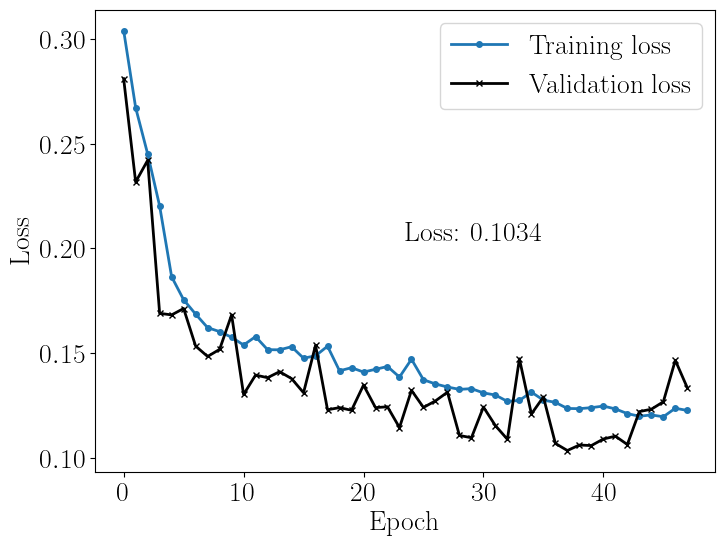

In [294]:
# Plot the training curves
loss = model_10.evaluate(val_dataset)
save_model(model_10,'model_energy')
print(f'Loss: {loss}')

import pickle
with open('models/trainHistoryDict_energy', 'wb') as file_pi:
    pickle.dump(history_10.history, file_pi)

plot_history(history_10, 'model_energy', loss, save_training_curves = False)


In [200]:
traject_energy = prediction(model_10,val_targets,val_data)


In [295]:
traject_energy_pre = prediction(pre_trained_model, val_targets, val_data)

In [312]:
t = train_data[0,:,0].reshape(-1,1)
traj_num = 2

# Brutus
N = data.shape[0]
e_b, e_pre, e_our = [], [], []
for traj_num in range(763):
    brutus_data = data[-int(N*0.1)-1:, :, :]
    brutus_v1 = brutus_data[traj_num, :, 5:7]
    brutus_v2 = brutus_data[traj_num, :, 7:9]

    brutus_p1 = brutus_data[traj_num, :, 1:3]
    brutus_p2 = brutus_data[traj_num, :, 3:5]
    brutus_p3 = -brutus_p1 - brutus_p2
    brutus_v3 = tf_compute_velocities(t, brutus_p3)

    init_energy_brutus = tf_compute_potential_energy(brutus_p1[0,:].reshape(1,-1), brutus_p2[0,:].reshape(1,-1), brutus_p3[0,:].reshape(1,-1))
    ke_brutus = tf_compute_kinetic_energy(brutus_v1) + tf_compute_kinetic_energy(brutus_v2) + tf_compute_kinetic_energy(brutus_v3)
    pe_brutus = tf_compute_potential_energy(brutus_p1, brutus_p2, brutus_p3)

    energy_brutus = ke_brutus + pe_brutus
    energy_error_brutus = init_energy_brutus - energy_brutus 
    energy_error_brutus = tf.clip_by_value(energy_error_brutus, -1e6, 1e6)
    e_b.append(energy_error_brutus)

    # Pre-trained model
    p1_pre = traject_energy_pre[:,:,0:2]
    p2_pre = traject_energy_pre[:,:,2:4]
    p3_pre = -p1_pre - p2_pre

    p1_val = val_targets[:,:,0:2]
    p2_val = val_targets[:,:,2:4]
    p3_val = -p1_val - p2_val

    init_energy_pre = tf_compute_potential_energy(p1_val[traj_num,0,:].reshape(1,-1), p2_val[traj_num,0,:].reshape(1,-1), p3_val[traj_num,0,:].reshape(1,-1))
    ke_pre = tf_compute_kinetic_energy(tf_compute_velocities(t, p1_pre[traj_num])) + tf_compute_kinetic_energy(tf_compute_velocities(t, p2_pre[traj_num])) + tf_compute_kinetic_energy(tf_compute_velocities(t, p3_pre[traj_num]))
    pe_pre = tf_compute_potential_energy(p1_pre[traj_num], p2_pre[traj_num], p3_pre[traj_num])

    energy_pre = ke_pre + pe_pre
    energy_error_pre = init_energy_pre - energy_pre
    energy_error_pre = tf.clip_by_value(energy_error_pre, -1e6, 1e6)
    e_pre.append(energy_error_pre)

    # Our ANN
    p1 = traject_energy[:,:,0:2]
    p2 = traject_energy[:,:,2:4]
    p3 = -p1 - p2

    init_energy = tf_compute_potential_energy(p1_val[traj_num,0,:].reshape(1,-1), p2_val[traj_num,0,:].reshape(1,-1), p3_val[traj_num,0,:].reshape(1,-1))
    ke = tf_compute_kinetic_energy(tf_compute_velocities(t, p1[traj_num])) + tf_compute_kinetic_energy(tf_compute_velocities(t, p2[traj_num])) + tf_compute_kinetic_energy(tf_compute_velocities(t, p3[traj_num]))
    pe = tf_compute_potential_energy(p1[traj_num], p2[traj_num], p3[traj_num])

    energy = ke + pe
    energy_error = init_energy - energy
    energy_error = tf.clip_by_value(energy_error, -1e6, 1e6)
    e_our.append(energy_error)

energy_error = np.sum(np.array(e_our), axis=0) / 763
energy_error_brutus = np.sum(np.array(e_b), axis=0) / 763
energy_error_pre = np.sum(np.array(e_pre), axis=0) / 763


[ 0.00000000e+00 -4.80524565e+01 -2.22419139e-02 -2.08341849e-02
 -1.93857206e-02 -1.86045642e-02 -1.69703283e-02 -1.52792246e-02
 -1.36150013e-02 -1.20148413e-02 -9.91859840e-03 -8.12628603e-03
 -6.13265116e-03 -5.12930144e-03 -4.01695538e-03 -4.09638801e-03
 -3.30771120e-03 -2.05475398e-03 -2.01336246e-03 -3.06236575e-03
 -1.52199042e-03  1.72229723e-04  1.42870803e-03  4.75219270e-03
  5.68310485e-03  7.22798787e-03  1.07168695e-02  1.33364106e-02
  1.51939882e-02  1.90033930e-02  2.57032666e-02  2.87114508e-02
  3.58470461e-02  4.64645656e-02  5.29874135e-02  5.88945119e-02
  6.07419576e-02  6.60358341e-02  7.23554054e-02  7.90791675e-02
  8.15034018e-02  8.63626312e-02  9.41084870e-02  9.44003677e-02
  9.54979315e-02  9.40671430e-02  8.97797018e-02  8.94885140e-02
  9.71938842e-02  1.05916304e-01  1.13263680e-01  1.19014466e-01
  1.23332663e-01  1.27822629e-01  1.30099611e-01  1.25770118e-01
  1.31531442e-01  1.37939571e-01  1.43537748e-01  1.54798705e-01
  1.63886680e-01  1.73293

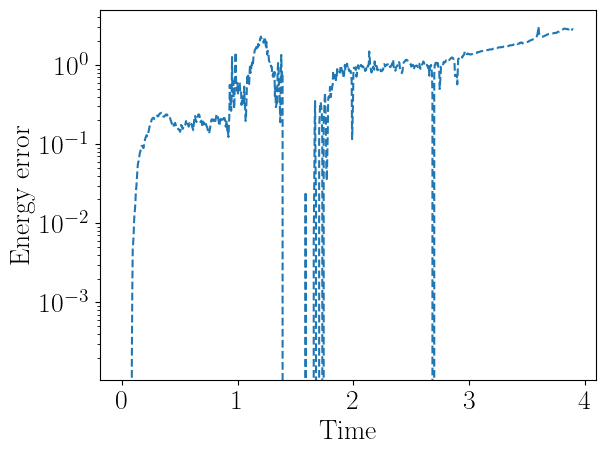

In [315]:
print(energy_error)
plt.semilogy(t, energy_error, '--')
#plt.semilogy(t, energy_error_brutus, '--')
#plt.semilogy(t, energy_error_pre, '--')
plt.xlabel('Time')
plt.ylabel('Energy error')

plt.show()